In [13]:
import os
import json
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from PIL import Image, ImageEnhance

%matplotlib notebook
import matplotlib.animation
import matplotlib.pyplot as plt

In [14]:
import conf

data_dir = "data/full_big"

batch_size = conf.training_batch_size
epochs = conf.training_epochs
img_height = conf.image_height
img_width = conf.image_width
img_channels = conf.image_depth

crop_top = conf.crop_top

class_nb = (len(conf.speed_idx), len(conf.angle_idx))

val_split = conf.val_split

model_name = "models/model_full_big_mse.h5"

In [15]:
raw_Y = []
for f in os.listdir(data_dir):
    if f.endswith(".json") and "meta" not in f:
        with open(os.path.join(data_dir, f)) as fd:
            data_id = f.split("_")[1].split(".")[0]
            data = json.load(fd)
            raw_Y.append({"id": int(data_id), "throttle": data["user/throttle"], "angle": data["user/angle"]})
            
raw_Y = sorted(raw_Y, key=lambda item: item["id"])
len(raw_Y)

117571

In [16]:
def plot_values(Y):
    fig, ax = plt.subplots(2,1)
    ax[0].plot([Y[i]["throttle"] for i in range(len(Y))])
    ax[1].plot([Y[i]["angle"] for i in range(len(Y))])

<IPython.core.display.Javascript object>


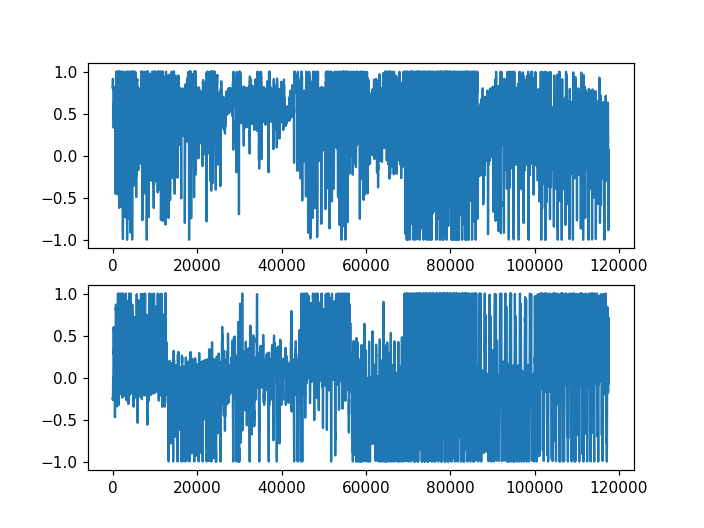

In [17]:
plot_values(raw_Y)

In [18]:
Y = raw_Y

<IPython.core.display.Javascript object>


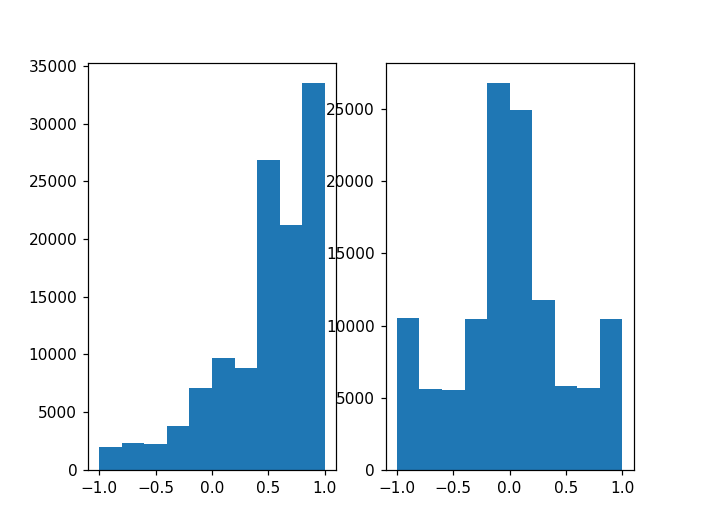

(array([10523.,  5580.,  5540., 10434., 26819., 24960., 11778.,  5834.,
         5659., 10444.]),
 array([-1.00001526e+00, -8.00015259e-01, -6.00015259e-01, -4.00015259e-01,
        -2.00015259e-01, -1.52590219e-05,  1.99984741e-01,  3.99984741e-01,
         5.99984741e-01,  7.99984741e-01,  9.99984741e-01]),
 <a list of 10 Patch objects>)

In [19]:
sum_sp = []
sum_dir = []

for v in Y:
    sum_sp.append(v["throttle"])
    sum_dir.append(v["angle"])

fig, ax = plt.subplots(1, 2)
ax[0].hist(sum_sp)
ax[1].hist(sum_dir)

In [20]:
class DataGenerator(Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, val=False, val_split=0.2, shuffle=False, mirror=False, noise=None, contrast=False, light=False):
        super().__init__()

        if val:
            self.data = [data[i] for i in range(int((1 - val_split) * len(data)), len(data))]
        else:
            self.data = [data[i] for i in range(0, int((1 - val_split) * len(data)))]
            
        self.val = val
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.mirror = mirror
        self.noise = noise
        self.contrast = contrast
        self.light = light
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def flip_img(self, X, y_dir):
        if np.random.randint(2):
            X = tf.image.flip_left_right(X)
            y_dir *= -1.0
        return X, y_dir
    
    def gaussian_noise(self, img, prob):
        noise = np.random.normal(1, prob ** 0.5, img.shape)
        img *= noise
        return img
    
    def add_rects(self, img):
        w = int(np.random.uniform(0.2, 0.4) * img_width)
        h = int(np.random.uniform(0.2, 0.4) * img_height)
        x = np.random.randint(img_width-w)
        y = np.random.randint(img_height-h)
        box = np.array([np.random.randint(0, 100, (h,w,1))])
        img[y:y+h, x:x+w] = box
        return img
        
    def add_noise(self, img):
        p = np.random.rand(1)
        if p < 0.3:
            return self.gaussian_noise(img, 0.02)
        elif p < 0.8:
            return self.add_rects(img)
        return img
    
    def random_light(self, img):
        rnd = np.random.uniform(0.2, 1.8)
        img *= rnd
        return img
    
    def random_contrast(self, img):
        contrast = ImageEnhance.Contrast(img)
        img = contrast.enhance(np.random.uniform(0.2, 1.8))
        return img
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_height - crop_top, img_width, img_channels), dtype=np.float32)
        y_speed = np.empty((self.batch_size), dtype=np.float32)
        y_dir = np.empty((self.batch_size), dtype=np.float32)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, idx in enumerate(indexes):

            img = Image.open(os.path.join(self.data_path, str(self.data[idx]["id"]) + "_cam-image_array_.jpg"))
            X[i,] = np.expand_dims(np.array(img)[...,0], 2)
            
            if self.val == False and self.light:
                X[i,] = self.random_light(X[i,])
            if self.val == False and self.noise:
                X[i,] = self.add_noise(X[i,])
            if self.val == False and self.mirror: 
                X[i,], y_dir[i,] = self.flip_img(X[i,], y_dir[i,])
            
            X[i,] = np.array(X[i,]) / 255.0
                

            y_speed[i,] = round(self.data[idx]["throttle"], 2)
            y_dir[i,] = round(self.data[idx]["angle"], 2)
            
        return X, [y_speed, y_dir]


In [21]:
random.shuffle(Y)

train_batches = DataGenerator(Y, data_dir, class_nb, batch_size=batch_size, val=False , val_split=0.4, shuffle=True, mirror=True, noise=False, light=True)
val_batches = DataGenerator(Y, data_dir, class_nb, batch_size=batch_size, val=True, val_split=0.4, shuffle=False, mirror=False)

1102 734


<IPython.core.display.Javascript object>


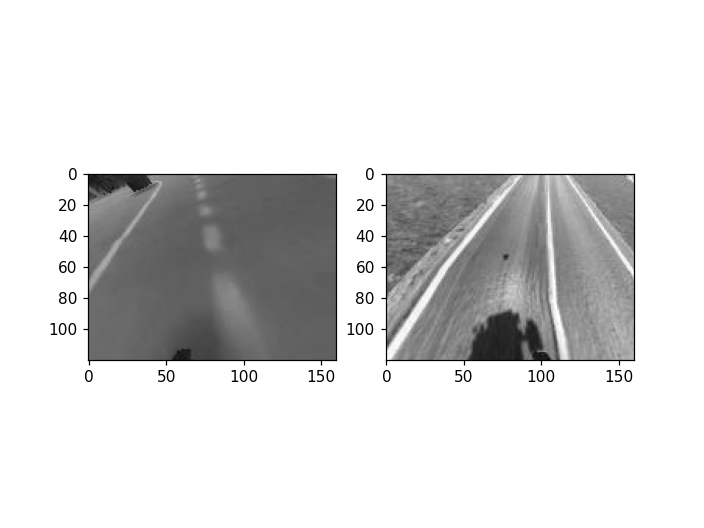

1.0 0.29 0.61 0.07


(120, 160, 3)

In [22]:
batch = 0
idx = 63

print(len(train_batches), len(val_batches))

train_test = train_batches[batch]
val_test = val_batches[batch]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(train_test[0][idx]), cmap="gray")
ax[1].imshow(np.squeeze(val_test[0][idx]), cmap="gray")
fig.show()
print(train_test[1][0][idx], train_test[1][1][idx], val_test[1][0][idx], val_test[1][1][idx])

train_test[0][idx].shape

<IPython.core.display.Javascript object>


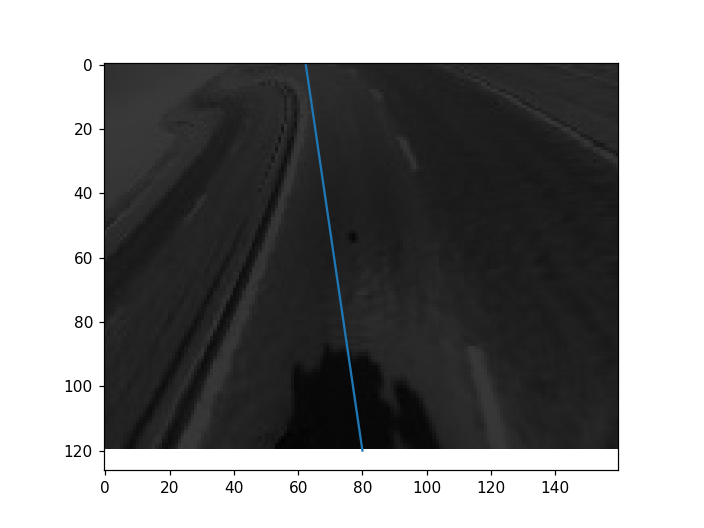

In [24]:
nb_frames = 2000

fig, ax = plt.subplots()
def animate(t):
    plt.cla()
    batch = train_batches[t // 128]
    img = batch[0][t % 128]
    plt.imshow(np.squeeze(img), cmap="gray")
    plt.plot((img_width // 2, (batch[1][1][t % 128] + 1) / 2 * img_width), (img_height, 0))
    plt.pause(0.01)
matplotlib.animation.FuncAnimation(fig, animate, frames=nb_frames)

In [18]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(img_height - crop_top, img_width, img_channels), name='img_in')
x = img_in

x = Convolution2D(24, (5,5), strides=(2,2), activation="relu")(x)
#x = BatchNormalization()(x)
#x = Activation("relu")(x)
x = Convolution2D(36, (5,5), strides=(2,2), activation="relu")(x)
#x = BatchNormalization()(x)
#x = Activation("relu")(x)
x = Convolution2D(48, (5,5), strides=(2,2), activation="relu")(x)
#x = BatchNormalization()(x)
#x = Activation("relu")(x)

x = Flatten(name='flattened')(x)

#x = Dense(200, activation="relu")(x)
#x = Dropout(0.5)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(10, activation="relu")(x)
x = Dropout(0.2)(x)
#x = Dense(50, activation="relu")(x)

# Multitask Output
out_speed = Dense(1, activation="tanh")(x)
out_dir = Dense(1, activation="tanh")(x)

opti = Optimizers.Adadelta(learning_rate=1.0)

# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='mse', optimizer=opti)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 58, 78, 24)   624         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 27, 37, 36)   21636       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 17, 48)   43248       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [19]:
#model = load_model("models/model_robo_cam_slow.h5")

In [20]:
#save best model if model improved
best_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [21]:
h = model.fit(train_batches, validation_data=val_batches, batch_size=batch_size, epochs=10, verbose=1, callbacks=[best_checkpoint])

Epoch 1/10
1102/1102 [==============================] - ETA: 0s - loss: 0.4482 - dense_2_loss: 0.1912 - dense_3_loss: 0.2570- ETA: 2s - loss: 0.4492 - dense_2_lo
Epoch 00001: val_loss improved from inf to 0.38924, saving model to models\model_full_big_mse.h5
1102/1102 [==============================] - 98s 89ms/step - loss: 0.4482 - dense_2_loss: 0.1912 - dense_3_loss: 0.2570 - val_loss: 0.3892 - val_dense_2_loss: 0.1439 - val_dense_3_loss: 0.2453
Epoch 2/10
1102/1102 [==============================] - ETA: 0s - loss: 0.3322 - dense_2_loss: 0.1242 - dense_3_loss: 0.2080- ETA: 0s - loss: 0.3322 - dense_2_loss: 0.1242 - dense_3_loss: 0.208
Epoch 00002: val_loss improved from 0.38924 to 0.20606, saving model to models\model_full_big_mse.h5
1102/1102 [==============================] - 98s 89ms/step - loss: 0.3322 - dense_2_loss: 0.1242 - dense_3_loss: 0.2080 - val_loss: 0.2061 - val_dense_2_loss: 0.0819 - val_dense_3_loss: 0.1242
Epoch 3/10
1102/1102 [==============================] - ETA:

<IPython.core.display.Javascript object>


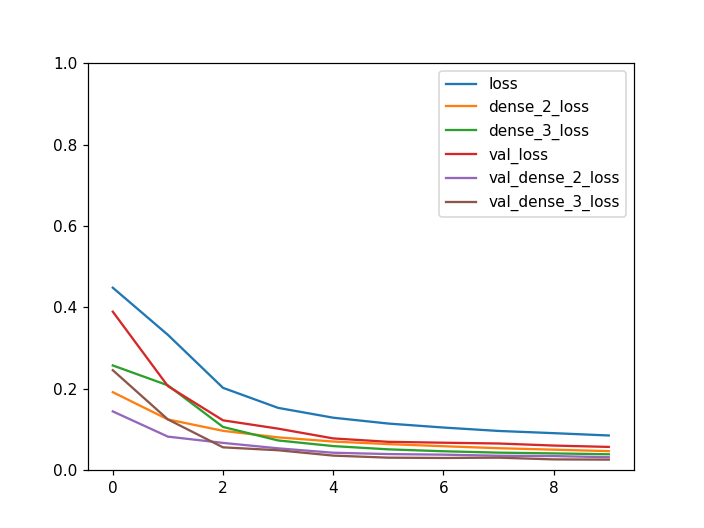

In [22]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [25]:
#model.save("models/model_test_overfit.h5")
model = load_model("models/model_full_big_mse.h5")

In [26]:
batch = 0
idx = 0

img = val_batches[batch][0][idx]

fig = plt.figure()
if img.shape[-1] == 1:
    plt.imshow(np.squeeze(img), cmap="gray")
else:
    plt.imshow(img)
fig.show()
pred = model.predict(np.array([img]))
print("speed : ", pred[0])
print("dir : ", pred[1])

<IPython.core.display.Javascript object>

ValueError: in user code:

    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Rock_\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 120, 160, 3]


<IPython.core.display.Javascript object>


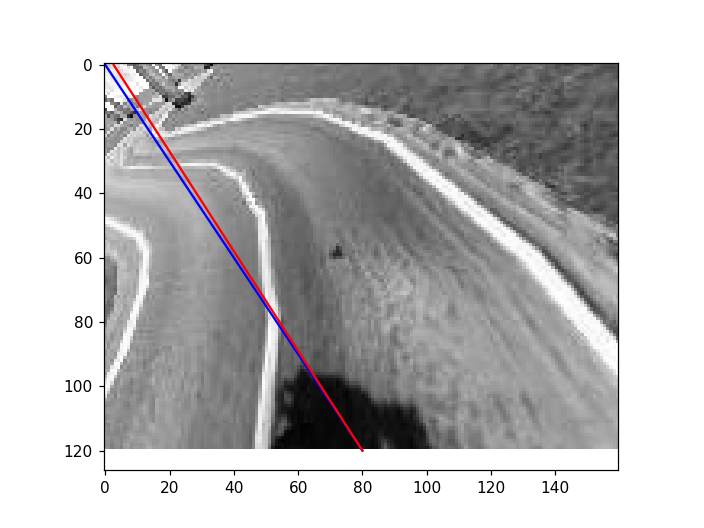

In [17]:
nb_frames = 2000

fig, ax = plt.subplots()
def animate(t):
    plt.cla()
    batch = val_batches[t // 128]
    img = [0][t % 128]
    if img.shape[-1] == 1:
        plt.imshow(np.squeeze(img), cmap="gray")
    else:
        plt.imshow(img)
    plt.plot((img_width // 2, (batch[1][1][t % 128] + 1) / 2 * img_width), (img_height, 0), color="blue")
    pred = model.predict(np.expand_dims(img, 0))[1]
    plt.plot((img_width // 2, (pred + 1) / 2 * img_width), (img_height, 0), color="red")
    
matplotlib.animation.FuncAnimation(fig, animate, frames=nb_frames)